<a href="https://colab.research.google.com/github/SilahicAmil/NLP/blob/main/Cyberbullying_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyberbullying Sentiment Analysis

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Tensorflow
import tensorflow as tf

# Keras
import keras
from keras.layers import Embedding, TextVectorization
from keras.metrics import categorical_accuracy

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [3]:
full_data = pd.read_csv("/content/drive/MyDrive/Random_Sentiment_Analysis/cyberbullying_tweets.csv")
full_data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
full_data.cyberbullying_type.value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

# Shuffle Data

In [5]:
shuffled_data = full_data.sample(frac=1, random_state=42)
shuffled_data.head()

,tweet_text,cyberbullying_type
40362,@Goree_JuhssGuns hahaha he ain't even worth my...,ethnicity
15019,RT @hsaymssik: Sucks to have the smile wiped o...,gender
46321,"Just a reminder, it's absolutely disgusting to...",ethnicity
23927,RT @BuzzFeedUK: When you accidentally open you...,other_cyberbullying
1640,Loving the look of the fritters! #mkr,not_cyberbullying


# Train Test Val Splitting

In [6]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(shuffled_data["tweet_text"].to_numpy(),
                                                                              shuffled_data["cyberbullying_type"].to_numpy(),
                                                                              test_size=0.2,
                                                                              random_state=42)

In [7]:
len(train_sentences), len(test_sentences)

(38153, 9539)

In [8]:
# Val set
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences,
                                                                            train_labels,
                                                                            test_size=0.10,
                                                                            random_state=42)

In [9]:
len(val_sentences), len(train_sentences)

(3816, 34337)

# One Hot Encoding

In [10]:
one_hot = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot.fit_transform(train_labels.reshape(-1, 1))
test_labels_one_hot = one_hot.fit_transform(test_labels.reshape(-1, 1))
val_labels_one_hot = one_hot.fit_transform(val_labels.reshape(-1, 1))

# Label Encoding

In [11]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.fit_transform(test_labels)
val_labels_encoded = label_encoder.fit_transform(val_labels)

In [12]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(6, array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
        'other_cyberbullying', 'religion'], dtype=object))

# Vectorization Prep

In [13]:
sent_lens = [len(i.split()) for i in train_sentences]
sent_lens[:5]

[5, 23, 50, 14, 20]

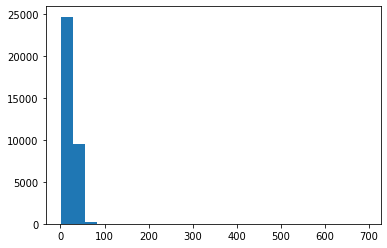

In [14]:
plt.hist(sent_lens, bins=25);

In [15]:
MAX_SENT_LEN = int(np.percentile(sent_lens, 99))
MAX_SENT_LEN

56

# Text Vectorization

In [16]:
MAX_VOCAB_LEN = 60_000


txt_vect = TextVectorization(max_tokens=MAX_VOCAB_LEN,
                             output_mode="int",
                             pad_to_max_tokens=True,
                             output_sequence_length=MAX_SENT_LEN)

In [17]:
txt_vect.adapt(train_sentences)

In [18]:
# Vocab len

vocab_len = txt_vect.get_vocabulary()
print(len(vocab_len))

55992


# Calc Results Function

In [19]:
def calc_result(y_true, y_pred):


  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  results = {"Accuracy": model_accuracy,
             "Precision": model_precision,
             "Recall": model_recall,
             "F1": model_f1}
  return results

In [43]:
def compile_model(model):
  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  
def fit_model(model, epochs):
  model.fit(train_dataset,
            epochs=epochs,
            validation_data=val_dataset,
            callbacks=[early_stop])

# Performant Datasets LUL

In [21]:
# Cant use sparse matrix since the length is ambigious and im 2 dumb to figure it out rn

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

# Conv1D model

In [22]:
Embedding = keras.layers.Embedding(input_dim=MAX_VOCAB_LEN,
                                   output_dim=128,
                                   input_length=MAX_SENT_LEN)

In [ ]:
tf.random.set_seed(42)

inputs = keras.layers.Input(shape=(1, ), dtype="string")

vect = txt_vect(inputs)

embed = Embedding(vect)

# COnv1d layers
x = keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(embed)
x = keras.layers.Conv1D(128, kernel_size=5, activation="relu")(x)

# Pooling
x = keras.layers.GlobalAveragePooling1D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# model creation
model_0 = keras.Model(inputs, outputs, name="Basline_Model")

In [ ]:
model_0.summary()

Model: "Basline_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 56)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 56, 128)           7680000   
                                                                 
 conv1d_2 (Conv1D)           (None, 56, 128)           82048     
                                                                 
 conv1d_3 (Conv1D)           (None, 52, 128)           82048     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                            

In [ ]:
compile_model(model_0)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5758f605-121b-7caf-d29e-a5e2b2217643)


without the GPU would've taken ~4+ mins per epoch. With a GPU only takes ~10s

In [ ]:
hist_0 = fit_model(model_0, 10)

Epoch 1/10
1074/1074 [==============================] - 12s 11ms/step - loss: 0.1329 - accuracy: 0.9515 - val_loss: 1.0680 - val_accuracy: 0.7930
Epoch 2/10
1074/1074 [==============================] - 13s 12ms/step - loss: 0.0438 - accuracy: 0.9797 - val_loss: 1.3827 - val_accuracy: 0.7890
Epoch 3/10
1074/1074 [==============================] - 12s 11ms/step - loss: 0.0419 - accuracy: 0.9797 - val_loss: 1.5566 - val_accuracy: 0.7872
Epoch 4/10
1074/1074 [==============================] - 13s 12ms/step - loss: 0.0387 - accuracy: 0.9814 - val_loss: 1.7602 - val_accuracy: 0.7835
Epoch 5/10
1074/1074 [==============================] - 11s 10ms/step - loss: 0.0389 - accuracy: 0.9820 - val_loss: 1.7397 - val_accuracy: 0.7801
Epoch 6/10
1074/1074 [==============================] - 9s 8ms/step - loss: 0.0368 - accuracy: 0.9828 - val_loss: 1.9208 - val_accuracy: 0.7733
Epoch 7/10
1074/1074 [==============================] - 10s 10ms/step - loss: 0.0364 - accuracy: 0.9827 - val_loss: 1.9438 - v

## Pred Probs

In [ ]:
model_0_pred_probs = model_0.predict(val_dataset)
model_0_pred_probs[:5]

array([[3.3468421e-04, 1.6313499e-05, 2.7886685e-02, 1.5423210e-02,
        9.5633847e-01, 6.4354049e-07],
       [7.9447800e-27, 1.0000000e+00, 3.2566630e-21, 0.0000000e+00,
        4.9881182e-24, 1.3546985e-27],
       [9.9998999e-01, 7.3568046e-08, 6.6598782e-10, 2.1661704e-10,
        9.9285298e-06, 8.6191219e-12],
       [1.9057572e-10, 2.5655122e-11, 9.9494910e-01, 7.0719672e-08,
        5.0508073e-03, 5.9093451e-12],
       [5.8045521e-06, 6.0894769e-07, 9.3614639e-05, 9.9748492e-01,
        2.4129907e-03, 2.0438913e-06]], dtype=float32)

In [ ]:
model_0_preds = tf.argmax(model_0_pred_probs, axis=1)
model_0_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 1, 0, 2, 3])>

In [ ]:
baseline_result = calc_result(val_labels_encoded,
                              model_0_preds)
baseline_result

{'Accuracy': 77.48951781970649,
 'F1': 0.7742124984564037,
 'Precision': 0.7750056775630435,
 'Recall': 0.774895178197065}

77.4% POGGGGGERZZZZZZZZ

# RNN Model

In [ ]:
tf.random.set_seed(42)

inputs = keras.layers.Input(shape=(1, ), dtype="string")

vect = txt_vect(inputs)

embed = Embedding(vect)

# RNN Layers
x = keras.layers.SimpleRNN(128, activation="relu")(embed)


# outputs
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# model creation
model_1 = keras.Model(inputs, outputs, name="SimpleRNN_Model")

In [ ]:
model_1.summary()

Model: "SimpleRNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 56)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 56, 128)           7680000   
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 7,713,670
Trainable params: 7,713,670
Non-trainable params: 0
_________________________________________

In [ ]:
compile_model(model_1)

In [ ]:
hist_1 = fit_model(model_1, 10)

Epoch 1/10
1074/1074 [==============================] - 91s 82ms/step - loss: 1.7838 - accuracy: 0.1793 - val_loss: 1.7748 - val_accuracy: 0.1892
Epoch 2/10
1074/1074 [==============================] - 83s 77ms/step - loss: 1.7894 - accuracy: 0.1789 - val_loss: 1.7846 - val_accuracy: 0.1792
Epoch 3/10
1074/1074 [==============================] - 83s 77ms/step - loss: 1.8786 - accuracy: 0.1889 - val_loss: 1.7244 - val_accuracy: 0.2338
Epoch 4/10
1074/1074 [==============================] - 82s 77ms/step - loss: 1.3287 - accuracy: 0.4266 - val_loss: 0.8973 - val_accuracy: 0.6840
Epoch 5/10
1074/1074 [==============================] - 84s 78ms/step - loss: 0.6061 - accuracy: 0.7854 - val_loss: 0.9704 - val_accuracy: 0.6884
Epoch 6/10
1074/1074 [==============================] - 83s 78ms/step - loss: 0.4703 - accuracy: 0.8461 - val_loss: 1.0344 - val_accuracy: 0.6499
Epoch 7/10
1074/1074 [==============================] - 176s 164ms/step - loss: 0.6985 - accuracy: 0.7536 - val_loss: 1.3018

Looks like after epochs 6 the accuracy stared going down. Probably good to use a early stopping callback but that can be done later when hyperparameter tuning and shit

## Calc Results

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[:5]

array([[9.1339223e-04, 1.1460104e-01, 2.9474881e-01, 2.5006181e-01,
        3.3004478e-01, 9.6302200e-03],
       [9.0148724e-06, 8.3034694e-01, 1.6963373e-01, 1.0241844e-06,
        4.8334100e-06, 4.4658700e-06],
       [9.9985027e-01, 0.0000000e+00, 0.0000000e+00, 5.1675221e-24,
        1.1001668e-30, 1.4969817e-04],
       [1.0635921e-03, 4.5294368e-01, 5.1821929e-01, 1.4180283e-02,
        1.0103062e-02, 3.4900911e-03],
       [6.2795356e-04, 3.4122404e-02, 7.8031667e-02, 3.6004516e-01,
        5.1790315e-01, 9.2696585e-03]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 1, 0, 2, 4])>

In [ ]:
model_1_results = calc_result(val_labels_encoded,
                              model_1_preds)
model_1_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 63.181341719077565,
 'F1': 0.5921440673156454,
 'Precision': 0.5907622779863172,
 'Recall': 0.6318134171907757}

# GRU Model

In [ ]:
tf.random.set_seed(42)

inputs = keras.layers.Input(shape=(1, ), dtype="string")

vect = txt_vect(inputs)

embed = Embedding(vect)

x = keras.layers.GRU(128, activation="relu")(embed)


#outputs
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#model creation
model_2 = keras.Model(inputs, outputs, name="GRU_Model")

In [ ]:
model_2.summary()

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 56)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 56, 128)           7680000   
                                                                 
 gru_11 (GRU)                (None, 128)               99072     
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 7,779,846
Trainable params: 7,779,846
Non-trainable params: 0
_______________________________________________

In [ ]:
compile_model(model_2)

In [ ]:
hist_2 = fit_model(model_2, 10)

Epoch 1/10
1074/1074 [==============================] - 207s 191ms/step - loss: 0.3624 - accuracy: 0.8469 - val_loss: 0.8344 - val_accuracy: 0.7977
Epoch 2/10
1074/1074 [==============================] - 205s 190ms/step - loss: 0.0635 - accuracy: 0.9738 - val_loss: 1.0814 - val_accuracy: 0.7951
Epoch 3/10
1074/1074 [==============================] - 204s 190ms/step - loss: 0.0444 - accuracy: 0.9816 - val_loss: 1.3245 - val_accuracy: 0.7773
Epoch 4/10
1074/1074 [==============================] - 204s 190ms/step - loss: 0.0363 - accuracy: 0.9848 - val_loss: 1.4643 - val_accuracy: 0.7807
Epoch 5/10
1074/1074 [==============================] - 203s 189ms/step - loss: 0.0353 - accuracy: 0.9848 - val_loss: 1.6834 - val_accuracy: 0.7579
Epoch 6/10
1074/1074 [==============================] - 204s 190ms/step - loss: 0.0359 - accuracy: 0.9855 - val_loss: 1.3323 - val_accuracy: 0.7904
Epoch 7/10
1074/1074 [==============================] - 199s 186ms/step - loss: 0.0333 - accuracy: 0.9870 - val_

## Calc Results

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs[:5]

array([[3.0231653e-05, 5.5336994e-07, 4.2047433e-04, 4.0769766e-04,
        9.9914098e-01, 2.0680162e-08],
       [3.2802109e-05, 9.9995446e-01, 1.5406616e-06, 4.2284736e-08,
        9.1015534e-07, 1.0353664e-05],
       [9.9998569e-01, 3.2718961e-09, 1.1943134e-11, 1.4348406e-05,
        3.6168750e-09, 2.3116453e-09],
       [1.0478160e-04, 2.2745244e-05, 9.9936885e-01, 1.3303686e-05,
        4.8499752e-04, 5.3341232e-06],
       [8.4703222e-02, 3.3788942e-04, 7.4596172e-03, 2.5863814e-01,
        6.4867657e-01, 1.8449157e-04]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 1, 0, 2, 4])>

In [ ]:
model_2_results = calc_result(val_labels_encoded,
                              model_2_preds)
model_2_results

{'Accuracy': 78.66876310272536,
 'F1': 0.7890726637785226,
 'Precision': 0.7932286703111062,
 'Recall': 0.7866876310272537}

78% POGGGGERZZZZZZZ

In [48]:
# Early Stop Callback

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",
                                           patience=3,
                                           restore_best_weights=True)

# GRU Model w/ Dense Layer

In [49]:
tf.random.set_seed(42)

inputs = keras.layers.Input(shape=(1, ), dtype="string")

vect = txt_vect(inputs)

embed = Embedding(vect)

# Conv1d
x = keras.layers.Conv1D(128, padding="same", activation="relu", kernel_size=5)(embed)
x = keras.layers.Conv1D(64, activation="relu", kernel_size=5)(x)

# Dropout
x = keras.layers.Dropout(0.2)(x)

# GRU Cell
x = keras.layers.GRU(128, activation="relu", return_sequences=True)(x)
x = keras.layers.GRU(64, activation="relu")(x)

# Dropout
x = keras.layers.Dropout(0.2)(x)

# Dense Layers
x = keras.layers.Dense(64, activation="relu")(x)

#outputs
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#model creation
model_3 = keras.Model(inputs, outputs, name="GRU_Model")

In [50]:
model_3.summary()

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 56)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 56, 128)           7680000   
                                                                 
 conv1d_15 (Conv1D)          (None, 56, 128)           82048     
                                                                 
 conv1d_16 (Conv1D)          (None, 52, 64)            41024     
                                                                 
 dropout_17 (Dropout)        (None, 52, 64)            0         
                                                         

In [51]:
compile_model(model_3)

In [52]:
hist_3 = fit_model(model_3, 50)

Epoch 1/50
1074/1074 [==============================] - 338s 303ms/step - loss: 0.8390 - accuracy: 0.6316 - val_loss: 0.5017 - val_accuracy: 0.7896
Epoch 2/50
1074/1074 [==============================] - 231s 215ms/step - loss: 0.4519 - accuracy: 0.8095 - val_loss: 0.4928 - val_accuracy: 0.8061
Epoch 3/50
1074/1074 [==============================] - 233s 217ms/step - loss: 0.3458 - accuracy: 0.8675 - val_loss: 0.4847 - val_accuracy: 0.8163
Epoch 4/50
1074/1074 [==============================] - 226s 211ms/step - loss: 0.2570 - accuracy: 0.9090 - val_loss: 0.5761 - val_accuracy: 0.7982
Epoch 5/50
1074/1074 [==============================] - 227s 212ms/step - loss: 0.1950 - accuracy: 0.9335 - val_loss: 0.6074 - val_accuracy: 0.8053
Epoch 6/50
1074/1074 [==============================] - 226s 211ms/step - loss: 0.1490 - accuracy: 0.9489 - val_loss: 0.6932 - val_accuracy: 0.7961


## Calc Results

In [53]:
model_3_pred_probs = model_3.predict(val_dataset)
model_3_pred_probs[:3]

array([[4.2279656e-03, 1.8694184e-03, 1.0991547e-01, 6.7601788e-01,
        2.0697552e-01, 9.9368615e-04],
       [1.1392683e-05, 9.9998808e-01, 3.0266341e-07, 1.1356424e-08,
        4.0132829e-08, 1.0625063e-07],
       [9.7563851e-01, 4.8524379e-03, 2.5958382e-04, 1.4594285e-02,
        6.2921498e-04, 4.0259464e-03]], dtype=float32)

In [54]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(3816,), dtype=int64, numpy=array([3, 1, 0, ..., 0, 2, 4])>

In [55]:
model_3_results = calc_result(val_labels_encoded,
                              model_3_preds)
model_3_results

{'Accuracy': 81.62997903563941,
 'F1': 0.8168373516534109,
 'Precision': 0.8271238760366632,
 'Recall': 0.8162997903563941}

81% POGGGGGGERZZZZZZZZZ